<a href="https://colab.research.google.com/github/wnqw/labProject/blob/master/VGG_Face_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preload

Mount the google drive and load necessary packages

In [ ]:
from google.colab import drive

from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 386 (delta 35), reused 29 (delta 9), pack-reused 307
Receiving objects: 100% (386/386), 8.37 MiB | 822.00 KiB/s, done.
Resolving deltas: 100% (212/212), done.
     \ 51.4MB 193kB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30857 sha256=7212469644c6641f35070f556b840f3f331ee4580a7ae712b8806ad5879916ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-0yq37ac6/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


Unpack the items

In [ ]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class
!unzip -q /content/drive/My\ Drive/obj/merge
!unzip -q /content/drive/My\ Drive/obj/vggface_files

# Load libraries
Load the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

### Merged Images

In [ ]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im) 
    return data

(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)
(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)


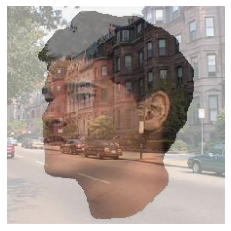

In [ ]:
# Merged images load
data_train = [[]  for i in range(12)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[8] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[9] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)
 
data_test = [[]  for i in range(12)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[8] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[9] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[0,1])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(12)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75
reg_train[4] = convertimgs('/content/merge/merge_reg_train/Correct/Powered',noise = False) # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[8] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[9] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
reg_train[10] = convertimgs('/content/merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
reg_train[11] = convertimgs('/content/merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(12)]
reg_test[0] = convertimgs('/content/merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs('/content/merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs('/content/merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs('/content/merge/merge_reg_test/Correct/Natural/',noise = False) #75
reg_test[4] = convertimgs('/content/merge/merge_reg_test/Correct/Powered',noise = False) #75
reg_test[5] = convertimgs('/content/merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[6] = convertimgs('/content/merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[7] = convertimgs('/content/merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[8] = convertimgs('/content/merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[9] = convertimgs('/content/merge/merge_reg_test/Incorrect/Natural',noise = False) #75
reg_test[10] = convertimgs('/content/merge/merge_reg_test/Incorrect/Powered',noise = False) #75
reg_test[11] = convertimgs('/content/merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)



### get attnmap


# Tuning Value Calculation

In [ ]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
calc_tun_activ = 0

if calc_tun_activ:
  for cat in range(6): 

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)



### Load tuning activities

In [ ]:
tun_activ = []
for interest in range(6): 
  with open ('/content/drive/My Drive/obj/tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)



240

### Calculation of tuning values for each map

In [ ]:
ncats = 6
# to fish out each category tun_activations
labels = np.array([0] * 40 + [1] * 40 + [2] * 40 + [3] * 40 + [4] * 40 + [5] * 40)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]


### Tuning quality

(0.0, 50.0)

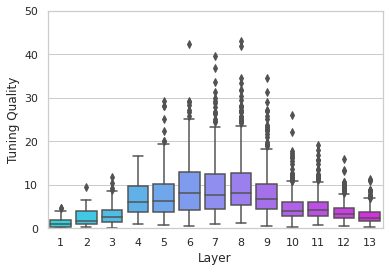

In [ ]:
tun_quality = tc.calc_tun_quality(fc)
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])

(0.0, 30.0)

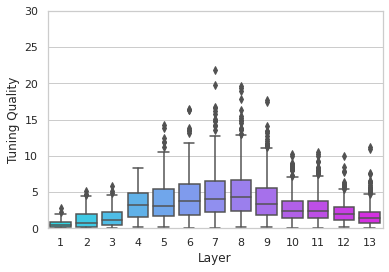

In [ ]:
tun_q_face = [[0 for item in subl] for subl in fc[0]]
for cat in range(2):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_face[layer][map] < abs(fc[cat][layer][map]):
        tun_q_face[layer][map] = abs(fc[cat][layer][map])

sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_q_face,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,30])

In [ ]:
def gen_attnmap(modifier,mask,category,bi,atype,rand_map):
    """
    

    Parameters
    ----------
    modifier : list
        modifier to be used to implement attention.
    mask : ndarray
        binary vector to determine which layer to apply attention at. 
        include attention strength by multiplying to it
    category : ndarray
        cateogies .
    bi : boolean 
        bidirectionality
        True & False.
    atype: int
        1 = Multiplicative
        2 = Additive
    rand_map: bool, optional
        Set to 'True' for random set of tuning values
    Returns
    -------
    tensor_attnmap : tensor
        attention map.

    """
    attnmap = []
    #beta = calc_beta(avg_tun_activ)/10
  
    #conv1_1 & conv1_2

    for layer in range(2):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[224,224,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          
          amap = np.ones((224,224,64),dtype='float32') +  mask[layer]
        attnmap.append(amap)
        
    
    #conv2_1 & conv2_2
    for layer in range(2,4):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[112,112,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((112,112,128),dtype='float32') +  mask[layer]
        attnmap.append(amap)
    
    #conv3_1 - conv3_3
    for layer in range(4,7):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[56,56,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((56,56,256),dtype='float32') + mask[layer]
        attnmap.append(amap)
    
    #conv4_1 - conv4_3
    for layer in range(7,10):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[28,28,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((28,28,512),dtype='float32') + mask[layer]
        attnmap.append(amap)
    
    #conv5_1 - conv5_3
    for layer in range(10,13):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype ==1:
          amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[14,14,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((14,14,512),dtype='float32') + mask[layer]
        attnmap.append(amap)
    
    
    
    tensor_attnmap = []
    for layer in range(len(attnmap)):
      tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer])) 
    
    return tensor_attnmap

# *Model*

In [ ]:
# Calling VGG16 without the top FC layers with weights loaded from imagenet 
vgg = VGG16(weights=None,
              include_top=False,input_shape = [224,224,3])

output = vgg.output
x = Flatten()(output)
x = Dense(4096,activation = 'relu')(x)
x = Dense(4096,activation = 'relu')(x)
x = Dense(2622,activation = 'softmax')(x)

model2 = Model(inputs = vgg.input, outputs = x)
model2.load_weights('/content/vggface_files/vggface_weights.h5')
#model2.summary()

model = VGG16(weights=None,
              include_top=False,input_shape = [224,224,3])

for layer in range(13):
  model.layers[layer].set_weights(model2.layers[layer].get_weights())

#plot_model(model,show_shapes=True,expand_nested=True)
#model.save_weights('vgg_w',save_format='h5')

categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')
epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest) 

losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense2')) 
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
#top_model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)


#================================================================================+
#alexnet:

# based on this picture: https://www.google.com/url?sa=i&url=http%3A%2F%2Fdatahacker.rs%2Fdeep-learning-alexnet-architecture%2F&psig=AOvVaw2NIKy0dBDDcqfMvnfQBXHr&ust=1626336623351000&source=images&cd=vfe&ved=0CAoQjRxqFwoTCKDiyJqO4vECFQAAAAAdAAAAABA1

alexnet = tf.keras.Sequential()

# conv1
alexnet.add(tf.layers.Conv2D(filters = 96, kernel_size = (11,11), input_shape=(32,32,3), activation='relu'))

# conv2
alexnet.add(tf.layers.Conv2D(filters = 256, kernel_size = (5,5), activation='relu'))
alexnet.add(tf.layers.MaxPooling2D((2, 2)))

#conv3
alexnet.add(tf.layers.Conv2D(filters = 384, kernel_size = (3,3), activation='relu'))
alexnet.add(tf.layers.MaxPooling2D((2, 2)))

#conv4
alexnet.add(tf.layers.Conv2D(filters = 384, kernel_size = (3,3), activation='relu'))

#conv5
alexnet.add(tf.layers.Conv2D(filters = 256, kernel_size = (3,3), activation='relu'))
alexnet.add(tf.layers.MaxPooling2D((2, 2)))

#FC1
alexnet.add(Dense(4096, activation='relu'))

#FC2
alexnet.add(Dense(4096, activation='relu'))

#FC3
alexnet.add(Dense(1000, activation='relu'))

#output layer
alexnet.add(Dense(2, activation='softmax'))





# Attention

### Att
(This is optional. The same code is written in vgg16obj/tools/model_calcs.py called separately in the next driver chunk

In [ ]:
vgg = VGG16(weights=None,
              include_top=False,input_shape = [224,224,3])

output = vgg.output
x = Flatten()(output)
x = Dense(4096,activation = 'relu')(x)
x = Dense(4096,activation = 'relu')(x)
x = Dense(2622,activation = 'softmax')(x)

model2 = Model(inputs = vgg.input, outputs = x)
model2.load_weights('/content/vggface_files/vggface_weights.h5')
model2.summary()

model = VGG16(weights=None,
              include_top=False,input_shape = [224,224,3])

for layer in range(13):
  model.layers[layer].set_weights(model2.layers[layer].get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 10 02:39:43 2020

@author: soukhind
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from vis.utils import utils
from tensorflow.python.ops import nn
from tensorflow import math
import time
from sklearn.metrics import roc_curve,accuracy_score,precision_recall_curve,f1_score
from sklearn.manifold import TSNE


def gen_attnmap(modifier,mask,category,bi,atype):
    """
    

    Parameters
    ----------
    modifier : list
        modifier to be used to implement attention.
    mask : ndarray
        binary vector to determine which layer to apply attention at. 
        include attention strength by multiplying to it
    category : ndarray
        cateogies .
    bi : boolean 
        bidirectionality
        True & False.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    tensor_attnmap : tensor
        attention map.

    """
    attnmap = []
    #beta = calc_beta(avg_tun_activ)/10
  
    #conv1_1 & conv1_2
    for layer in range(2):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[224,224,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv2_1 & conv2_2
    for layer in range(2,4):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[112,112,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv3_1 - conv3_3
    for layer in range(4,7):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[56,56,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv4_1 - conv4_3
    for layer in range(7,10):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[28,28,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv5_1 - conv5_3
    for layer in range(10,13):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype ==1:
          amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[14,14,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    tensor_attnmap = []
    for layer in range(len(attnmap)):
      tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer])) 
    
    return tensor_attnmap

def calc_tsne_plots(model,data,layer1,model_type):
  """

    Parameters
    ----------
    model : Tensorflow Model
        The model that is of interest
        
    data : ndarray
        Testing data
    layer1 : layer name whose activations are to be extracted
        string
    model_type : int
        Type of model
        0 = Base Model
        1 = Top Model
    Returns
    -------
    fig
        Figure object

    """


  out = model.get_layer(layer1).output
  model_out = Model(model.input,out)
  tsne = TSNE()

  features = model_out.predict(data) 

  catunits = np.zeros((len(features),1000))
  
  if model_type == 0:
    for image in range(len(features)):
      x = np.ndarray.flatten(features[image])
      catunits[image,:] = np.random.choice(x,1000)
    reduced = tsne.fit_transform(catunits)
  
  else:
    reduced = tsne.fit_transform(features)

  reduced_transformed = reduced - np.min(reduced, axis=0)
  reduced_transformed /= np.max(reduced_transformed, axis=0)
  image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))
  fig = plt.figure(figsize = (10,10))
  palette = sns.color_palette("bright", 2)
  ax = sns.scatterplot(x = reduced[:,0], y = reduced[:,1], 
                hue = [0] * ntest + [1]*ntest,
                style = [0] * ntest + [1]*ntest,
                markers = ['v','X'], s = 300,
                  legend='full', palette=palette)
  plt.axis( 'off')
  return fig

def avg_accuracy(data_train,train_labels,
                 data_test,test_labels,
                 modifier,
                 model,top_model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1):
    """
    

    Parameters
    ----------
    data_train : ndarray
        Training data.
    train_labels : categorical
        Training labels.
    data_test : ndarray
        Testing data.
    test_labels : categorical
        Testing labels.
    category : int
        Catrgory index
    modifier : list
        modifier to be used to implement attention.
    model : keras model
        base model.
    top_model : keras model
        top model.
    idxpath : string
        for internal use.
    atstrng : float32
        attention strength.
    bidir : bool, optional
        Bidirectionality. The default is True.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    t_acc
        Accuracy for each category at each layer.

    """
    categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']

    epochs = 30    
    n_layers = 13
    t_acc = np.zeros(n_layers)
    thr = np.zeros(n_layers)
    for li in range(n_layers):
        layermask = np.zeros(13)
        layermask[li] = 1
        tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype)
        
        
        def attnrelu(x,map = tensor_attnmap,atype = atype):
            layeridx = np.load(idxpath)
            if layeridx == 13:
                layeridx = 0
            if atype == 1:
              x = nn.relu(x)
              activations = math.multiply(x,map[layeridx])
            if atype == 2:
              activations = math.add(x,map[layeridx])
              activations = nn.relu(activations)
            layeridx += 1
            np.save(idxpath,layeridx)
            return activations
    
        get_custom_objects().update({'attnrelu': Activation(attnrelu)})
    
        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu
    
        utils.apply_modifications(model)
        model.compile()
        
        f_train = model.predict(data_train)     
    
        f_test = model.predict(data_test)

        fig = calc_tsne_plots(model,data_test,
                        layer1 = 'block5_conv3',
                        model_type = 0
                        )
        fig.suptitle('Category: ' + categories[category] +
                     ', layer ' + str(li + 1) +
                     ', atstg ' + str(atstrng) + ', base_model', fontsize = 12)
        fig.savefig('/content/tsne_face_plots/tsne_base_cat'+ str(category) +
                    '_lyr' + str(li + 1) + '_astg' +  str(atstrng))
        
        es = EarlyStopping(monitor='loss', mode='min', verbose=1)
  
        history = top_model.fit(x = f_train,  y = train_labels,
                epochs=epochs,
                batch_size=64,
                verbose = 0, callbacks = [])
        
        fig = calc_tsne_plots(top_model,f_test,
                        layer1 = 'top_dense2',
                        model_type = 1
                        )
        fig.suptitle('Category: ' + categories[category] +
                     ', layer ' + str(li + 1) +
                     ', atstg ' + str(atstrng) + ', top_model', fontsize = 12)
        fig.savefig('/content/tsne_face_plots/tsne_top_cat'+ str(category) +
                    '_lyr' + str(li) + '_astg' +  str(atstrng))
    
        out = top_model.evaluate(f_test, test_labels)
        t_acc[li] = out[1]

    return t_acc


def calc_beta(avg_act):
  beta = [0 for item in avg_act]
  for layer in range(len(avg_act)):
    for item in avg_act[layer]:
      beta[layer] += np.mean(item)
      beta = np.array(beta)
  return beta

### Driver
This is the big loop which applies attention at each layer separately as a function of different attentional strengths. 
PS. This is very heavy and requires hours to finish.


In [ ]:
#@title Multiplicative and bidirectionality corrected
if os.path.isfile('tsne_face_plots/'):
  os.mkdir('tsne_face_plots/')
from vgg16obj.tools import model_calcs as mc
import gc
layeridx = 0
np.save('layeridx',layeridx)
#atstrng = 10.5 #0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10
for atstrng in np.arange(0,10,1): #Calling for different attn strengths
  grand_acc = [[] for i in range(6)] 
  for cat in range(6): # Iterating over 6 categories
    tf.keras.backend.clear_session()
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Training on regular data
    test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Testing on merged data
    print(train_it.shape,test_it.shape)
    model = VGG16(weights= None,
                        include_top=False,input_shape = [224,224,3])
    
    for layer in range(13):
      model.layers[layer].set_weights(model2.layers[layer].get_weights())
    top_model = Sequential()
    top_model.add(Flatten(input_shape=features_train.shape[1:])) 
    top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
    top_model.add(Dense(4096, activation='relu',name = 'top_dense2')) 
    top_model.add(Dense(2, activation='sigmoid',name = 'predictions'))
    top_model.compile(optimizer= Adam(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    # Read avg_accuracy's definition to learn about the parameters
    grand_acc[cat] = avg_accuracy(train_it,
                              train_labels,
                              test_it,
                              test_labels,
                              fc,
                              model,
                              top_model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1 )
  grand_acc = np.array(grand_acc)
  grand_acc.reshape([1,6,13])
  # Use tun_accuracy_multi for multiplicative mode (atype = 1) and
  # use tun_accuracy_bias for bias mode (atype = 2)
  np.save('tun_accuracy_bias' + str(atstrng),grand_acc)



Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 5ms/step - loss: 0.7807 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.7930 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.8026 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.8202 - accuracy: 0.7625
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.7988 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.9442 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.0591 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.1280 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.1735 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.2164 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.2627 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.3110 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.3404 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.3749 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.4071 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.4274 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.4568 - accuracy: 0.7250
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.3923 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.3886 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.3897 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.4006 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.4046 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.4221 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.4272 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.4340 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.4410 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.4444 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.4523 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.4567 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.4613 - accuracy: 0.8375
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.4649 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.4816 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.5100 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.5313 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.5459 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.5662 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.5806 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.5939 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.6036 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.6152 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.6234 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.6305 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.6368 - accuracy: 0.7625
Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.9124 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.9807 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.1825 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.2279 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.3113 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.3789 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.4380 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.5083 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.5432 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.5658 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.6158 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.6580 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.6742 - accuracy: 0.5875
Category of interest:  Nonpowered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.9273 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.1215 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.3281 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.4171 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.5349 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.5835 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.6960 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.7496 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.7899 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.8299 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.8825 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.9085 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.9568 - accuracy: 0.5750
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.4976 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.4773 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.5390 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.6449 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.6203 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.5942 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.1598 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 2.5321 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.4184 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.7087 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.1455 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.7229 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.5138 - accuracy: 0.7875
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.7824 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.8364 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.2204 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.2441 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.8660 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.2873 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.1408 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 2.1747 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.2616 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.9292 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.9610 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.9772 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 13ms/step - loss: 0.9241 - accuracy: 0.6375
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.4107 - accuracy: 0.8000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.8065 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.4844 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.6344 - accuracy: 0.8250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.8528 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.8851 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.8787 - accuracy: 0.8500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.0552 - accuracy: 0.8250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.8097 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.4737 - accuracy: 0.8250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.4885 - accuracy: 0.8000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.5445 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.4075 - accuracy: 0.8375
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.5172 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.7286 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.6228 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.7488 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.7409 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.5424 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.8974 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 2.0586 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.1974 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.5875 - accuracy: 0.8000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.7621 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.5413 - accuracy: 0.7625
Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.8689 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.6341 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.9400 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.8315 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.0275 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.9661 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.6984 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 2.3129 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.8585 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.2271 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.3084 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.4132 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.1926 - accuracy: 0.5875
Category of interest:  Nonpowered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.7859 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.5095 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.9430 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.8350 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.7859 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.0108 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.5433 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 2.8980 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.8842 - accuracy: 0.5500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.1955 - accuracy: 0.5375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.2674 - accuracy: 0.5375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.2002 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.1759 - accuracy: 0.6000
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.5171 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.5041 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.5470 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.8304 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.6762 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.0497 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.7718 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 2.4635 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.9246 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.7708 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.0407 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.7089 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.6729 - accuracy: 0.7625
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.7750 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.9152 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.9061 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 1.2522 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.0228 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 2.4237 - accuracy: 0.5500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.3354 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 2.9339 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.4592 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.9659 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.0177 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.0982 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.9911 - accuracy: 0.6625
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.4555 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.4654 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.7126 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 2.0667 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.4297 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 2.1737 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.0526 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 2.0737 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.6427 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.1329 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.7128 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.4823 - accuracy: 0.7875
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.6111 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.1958 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.6731 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.1810 - accuracy: 0.8000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.9439 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 2.1772 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.9235 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 5.1336 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 2.5006 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.9547 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.8405 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.8540 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.7258 - accuracy: 0.7375
Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.9199 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 3.5354 - accuracy: 0.5500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.2043 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.9578 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.9499 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.8021 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.7401 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 4.2562 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 13ms/step - loss: 2.1273 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.1614 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.7790 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.1650 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 1.4079 - accuracy: 0.6000
Category of interest:  Nonpowered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.7738 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.6257 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.9695 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.9807 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.8984 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.9611 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.5928 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 4.6635 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 2.6295 - accuracy: 0.5375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.2669 - accuracy: 0.5625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.2861 - accuracy: 0.5500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.2255 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.3477 - accuracy: 0.5625
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.4268 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.5621 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.5795 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.9404 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.6703 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.4103 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.0038 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 3.0744 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.7452 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.5423 - accuracy: 0.8125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.8078 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.5605 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.6238 - accuracy: 0.7625
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.7935 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.9301 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.9759 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.2009 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.3551 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 3.0492 - accuracy: 0.5375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.1340 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 5.1319 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 2.3452 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.0002 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.3147 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.9296 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.9588 - accuracy: 0.6625
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.5367 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 2.0474 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.6510 - accuracy: 0.8000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.0271 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 2.5328 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.4109 - accuracy: 0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 3.9241 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 3.8158 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 3.7466 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.1796 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.7124 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.7163 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.3982 - accuracy: 0.8250
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.5560 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.5566 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.7973 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.1716 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.8776 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 2.7527 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 3.1062 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 6.1273 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 2.7472 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.6147 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 2.3272 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.1601 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.8070 - accuracy: 0.7125
Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.5956 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 2.9039 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.8188 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.8138 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 0.7333 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.8920 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.7588 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 4.8300 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 2.4695 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.1300 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 1.7001 - accuracy: 0.5625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.6451 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.3004 - accuracy: 0.6375
Category of interest:  Nonpowered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.5241 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.8096 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 0.9609 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.9874 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.0271 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.9663 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 2.1816 - accuracy: 0.5625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 3.9688 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 14ms/step - loss: 2.5259 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 1.6336 - accuracy: 0.5500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.2635 - accuracy: 0.5625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.3755 - accuracy: 0.5625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.4159 - accuracy: 0.5875
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.5354 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.5186 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.5831 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.8566 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.1029 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 2.3579 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.8622 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 4.0639 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 2.2141 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 16ms/step - loss: 0.8681 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.7543 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.8955 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.0280 - accuracy: 0.7375
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.8857 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.9473 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.0816 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.7050 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 1.4811 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 3.1255 - accuracy: 0.5625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.4749 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 4.7412 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 2.5588 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.1491 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.7099 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.4960 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.1544 - accuracy: 0.6750
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 0.5309 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 2.2011 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 1.3598 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 4.0343 - accuracy: 0.7625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 3.0941 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 2.8166 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 5.6969 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 4.0663 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 14ms/step - loss: 2.4582 - accuracy: 0.8625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.1645 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 2.1798 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.1095 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.7536 - accuracy: 0.8000
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.5926 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.3970 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.6347 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 1.8175 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.2462 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 3.7219 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 4.6866 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 11.8420 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 3.0628 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.3405 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.2196 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.0195 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.9619 - accuracy: 0.7000
Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 0.6204 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 2.5045 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.9518 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.0475 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.9664 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 1.6103 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 2.8199 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.9044 - accuracy: 0.5500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.9487 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.2171 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.4850 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.1278 - accuracy: 0.5750
Category of interest:  Nonpowered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.5778 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.6151 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.1590 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.0945 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 13ms/step - loss: 1.0906 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 1.2213 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 2.2032 - accuracy: 0.5625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 3.9946 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 2.3402 - accuracy: 0.5625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.0692 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 13ms/step - loss: 1.4618 - accuracy: 0.5625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.4003 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.2166 - accuracy: 0.5500
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.5883 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.5140 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.6452 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.0645 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.8628 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 2.0888 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 2.0875 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 5.3562 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 2.7685 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.7405 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 0.9748 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 0.8224 - accuracy: 0.8125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.8517 - accuracy: 0.7250
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.9579 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.1023 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.3813 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.8644 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 2.6333 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 2.9961 - accuracy: 0.5625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 1.7315 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 4.7157 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 3.5764 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 16ms/step - loss: 1.8667 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 14ms/step - loss: 2.3019 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.5789 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.7357 - accuracy: 0.6750
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 0.6015 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 3.2382 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 9ms/step - loss: 1.2475 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.9877 - accuracy: 0.8250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 2.4267 - accuracy: 0.7875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 7ms/step - loss: 5.4510 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 13ms/step - loss: 8.1099 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 2.2322 - accuracy: 0.8125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 4.5067 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.3317 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.9049 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.0159 - accuracy: 0.7750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.8832 - accuracy: 0.7750
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.6710 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 2.5890 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.7282 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 3.3310 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.3275 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 6.5431 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 6.5772 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 14ms/step - loss: 7.9162 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 4.1467 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.4683 - accuracy: 0.7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.7602 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.4892 - accuracy: 0.7125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 0.9089 - accuracy: 0.7125
Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.6012 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 1.9561 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 14ms/step - loss: 0.9145 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 10ms/step - loss: 0.9260 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 1.0002 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.7950 - accuracy: 0.6750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 17ms/step - loss: 1.9894 - accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 13ms/step - loss: 2.8251 - accuracy: 0.7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 3.3566 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.7146 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 1.8137 - accuracy: 0.6500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.6983 - accuracy: 0.5750


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.3321 - accuracy: 0.6000
Category of interest:  Nonpowered
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 0.5744 - accuracy: 0.7375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 2.6976 - accuracy: 0.6875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 1.3624 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 14ms/step - loss: 1.2582 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.8389 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 8ms/step - loss: 0.9749 - accuracy: 0.6625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 1.6918 - accuracy: 0.5875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 5ms/step - loss: 10.0916 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 6ms/step - loss: 3.7693 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 13ms/step - loss: 1.8037 - accuracy: 0.6125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 12ms/step - loss: 2.4020 - accuracy: 0.6375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 1.6420 - accuracy: 0.6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 4ms/step - loss: 2.0735 - accuracy: 0.5500
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 11ms/step - loss: 0.6477 - accuracy: 0.7250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [ ]:
grand_acc = np.array(grand_acc)
grand_acc.reshape([1,6,13])
np.save('tun_accuracy_new' + str(atstrng),grand_acc)

Text(0, 0.5, 'Avg. acc.')

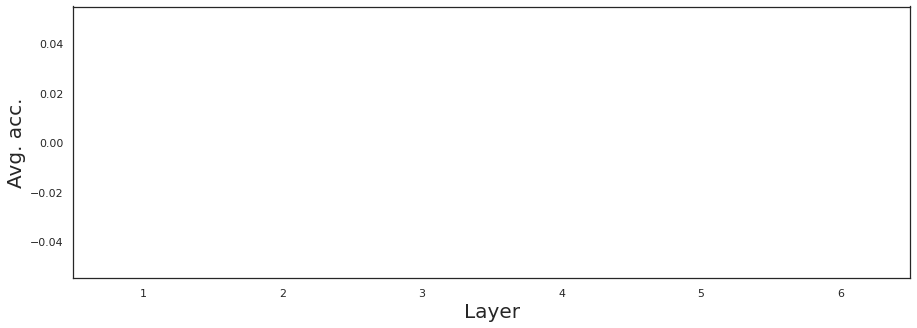

In [ ]:
import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (15,5))
ax = sns.pointplot(data = grand_acc, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Avg. acc.',size = 20)


### Regular Accuracy
Calculate the regular accuracy so that they can be contrasted against when attention is applied.

In [ ]:
# Reinitialising the models for calculating regular accuracy
model = VGG16(weights=None,
              include_top=False,input_shape = [224,224,3])

for layer in range(13):
  model.layers[layer].set_weights(model2.layers[layer].get_weights())

          
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')
epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest) 

losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
#top_model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)

categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
iter = 10

acc = np.zeros((iter,6))
for i in range(iter):
  for cat in range(6):

    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Train on regular data
    
    test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Test on merged data
    print(train_it.shape,test_it.shape)

    
    start = time.time()
    train_data = model.predict(train_it) 
    print(f'Train Time: {time.time() - start}')

    start = time.time()
    test_data = model.predict(test_it) 
    print(f'Test Time: {time.time() - start}')
    
    history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 0, callbacks = [es])

    out = top_model.evaluate(test_data, test_labels)
    acc[i,cat] = out[1]
    print(out)

In [ ]:
acc = np.mean(acc,0)
acc

array([0.67125   , 0.60375   , 0.61      , 0.69124999, 0.47625   ,
       0.58125001])

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.24963951110839844
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.16490554809570312
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.16305303573608398
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.16320276260375977
Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.15823912620544434
Category of interest:  Nonpowered
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.16734552383422852


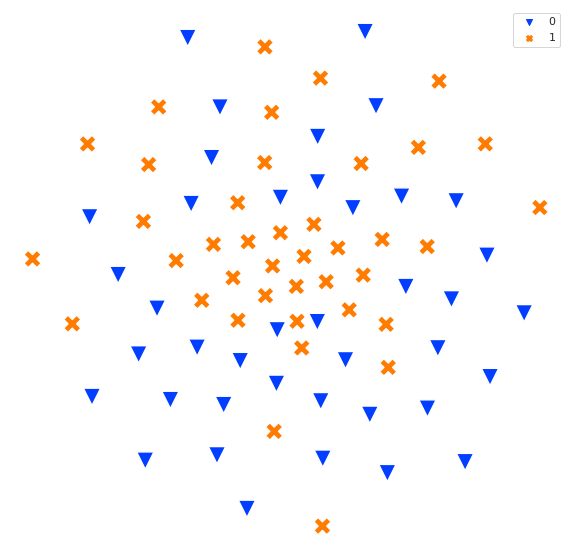

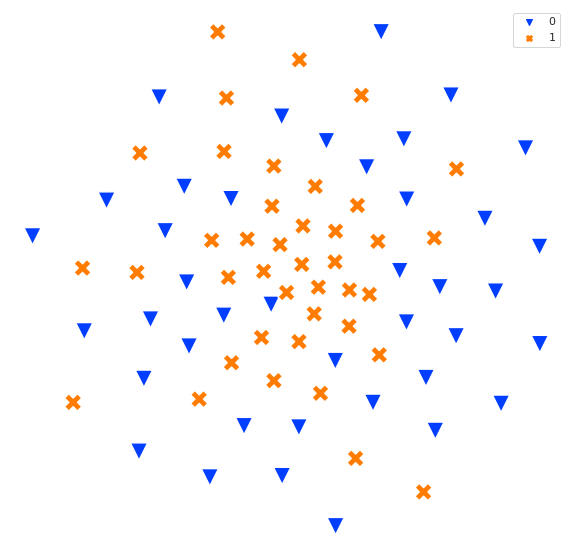

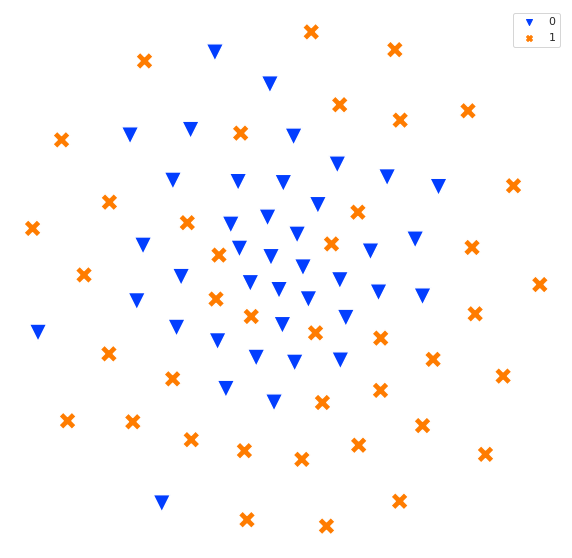

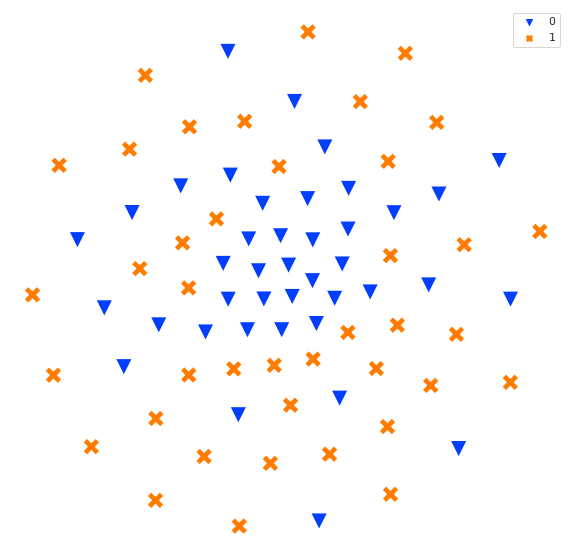

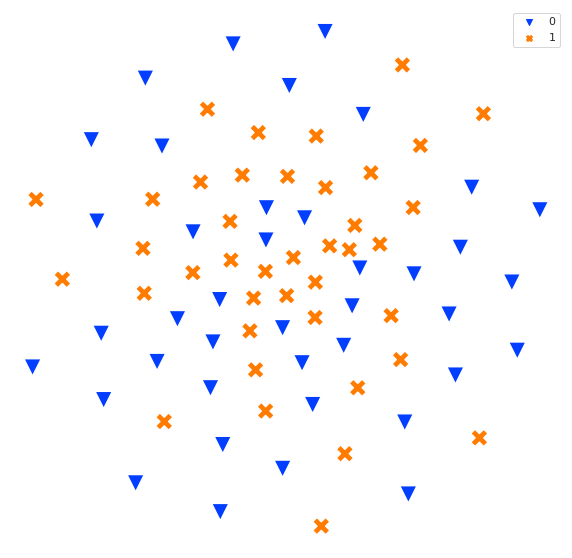

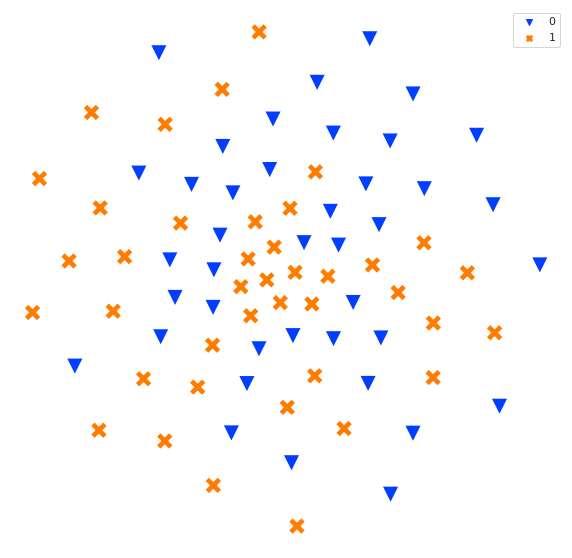

In [ ]:
from sklearn.manifold import TSNE

categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']

out = model.get_layer('block5_conv3').output
model_fc7 = Model(model.input,out)
tsne = TSNE()
rndperm = np.random.permutation(80)
df = pd.DataFrame(np.zeros(80))

imtype = 0
for cat in range(6):
  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Train on regular data
  if imtype == 0: # Regular
    test_it = np.concatenate((reg_test[cat],reg_test[cat + 6])) # Test on regular data
  else:
    test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Test on merged data
  print(train_it.shape,test_it.shape)

  
  start = time.time()
  features = model_fc7.predict(test_it) 
  print(f'Train Time: {time.time() - start}')


  catunits = np.zeros((len(features),1000))

  for image in range(len(features)):
    x = np.ndarray.flatten(features[image])
    catunits[image,:] = np.random.choice(x,1000)
  if cat == 0:
    units = catunits
  else:
    units = np.vstack((units,catunits))

  reduced = tsne.fit_transform(catunits)
  reduced_transformed = reduced - np.min(reduced, axis=0)
  reduced_transformed /= np.max(reduced_transformed, axis=0)
  image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))
  plt.figure(figsize = (10,10))
  palette = sns.color_palette("bright", 2)

  ax = sns.scatterplot(x = reduced[:,0], y = reduced[:,1], 
                  hue = [0] * ntest + [1]*ntest,
                  style = [0] * ntest + [1]*ntest,
                  markers = ['v','X'], s = 300,
                   legend='full', palette=palette)
  plt.axis( 'off')

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.380934476852417
Test Time: 0.21884679794311523


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.3955981731414795
Test Time: 0.23045611381530762
Epoch 00006: early stopping


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.3841433525085449
Test Time: 0.2212531566619873
Epoch 00016: early stopping


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.3935093879699707
Test Time: 0.22144293785095215


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.3778810501098633
Test Time: 0.21836209297180176
Epoch 00010: early stopping


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Nonpowered
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.38530778884887695
Test Time: 0.22350716590881348
Epoch 00005: early stopping


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


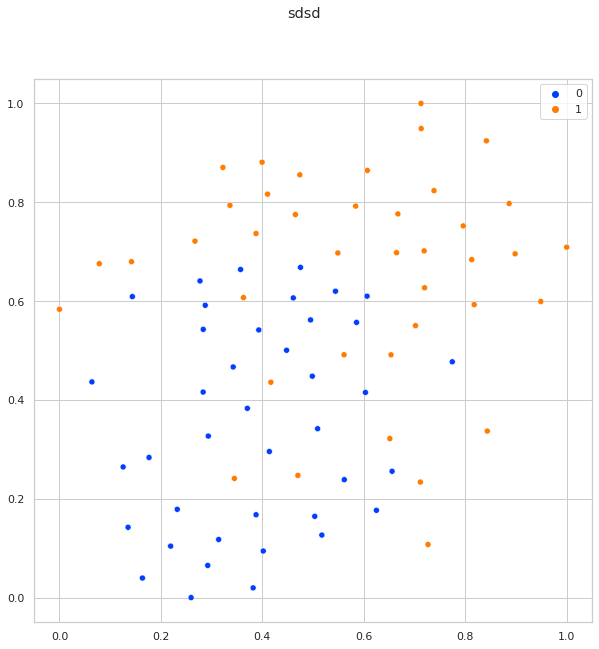

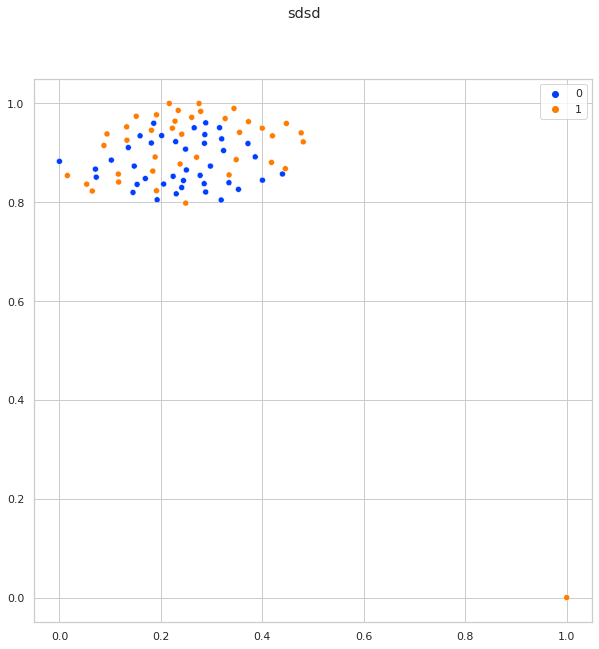

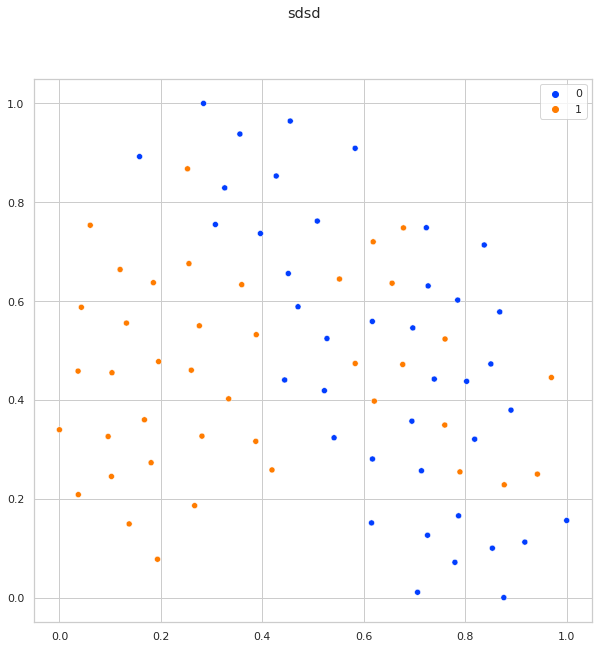

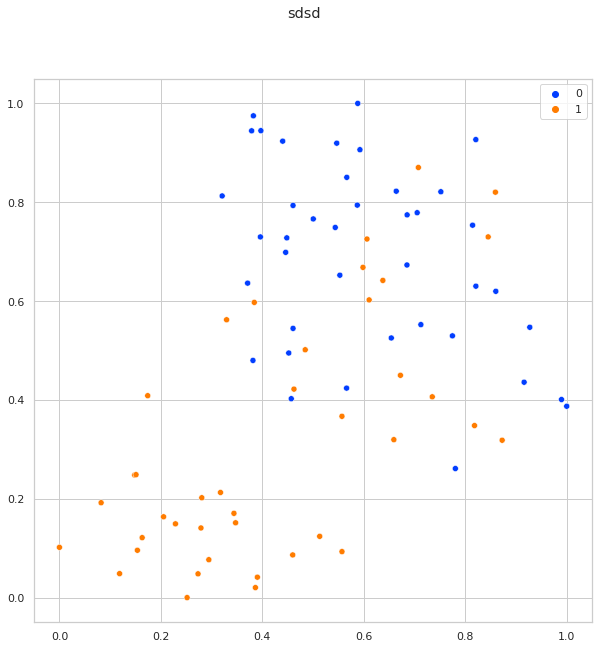

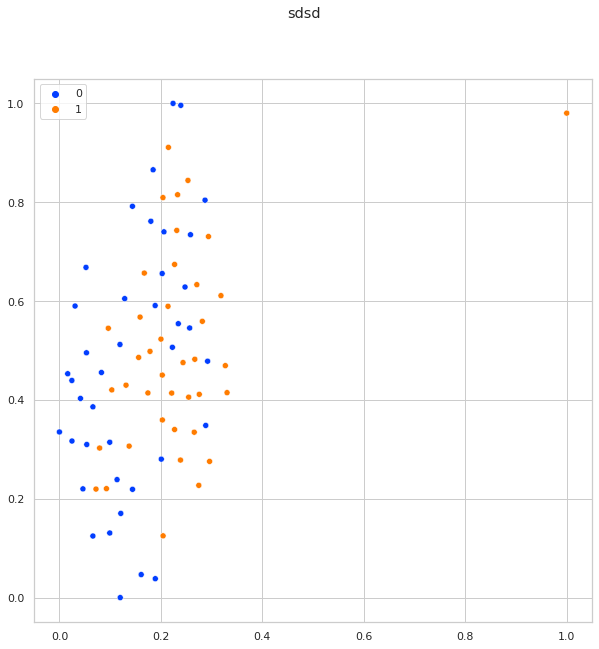

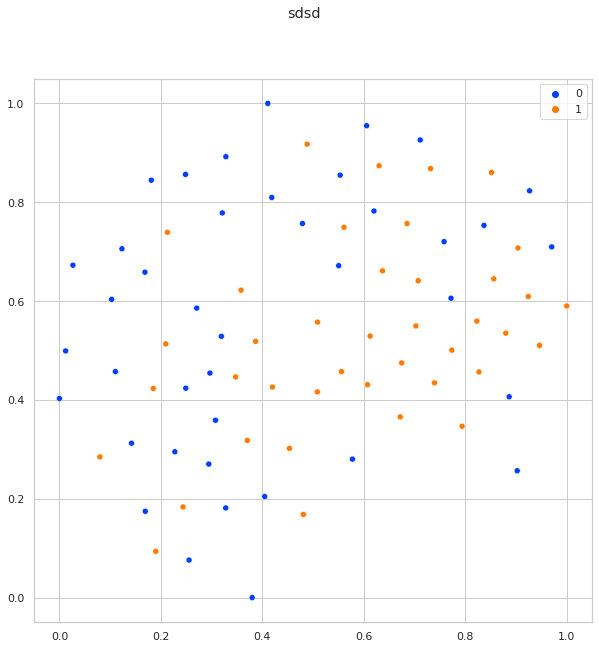

In [ ]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
out = top_model.get_layer('top_dense2').output
top_model_mod = Model(top_model.input,out)

imtype = 1
for cat in range(6):

  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Train on regular data
  if imtype == 0: # Regular
    test_it = np.concatenate((reg_test[cat],reg_test[cat + 6])) # Test on regular data
  else:
    test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Test on merged data
  print(train_it.shape,test_it.shape)

  
  start = time.time()
  train_data = model.predict(train_it) 
  print(f'Train Time: {time.time() - start}')

  start = time.time()
  test_data = model.predict(test_it) 
  print(f'Test Time: {time.time() - start}')
  
  history = top_model.fit(x = train_data,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          verbose = 0, callbacks = [es])

  features = top_model_mod.predict(test_data)
  
  reduced = tsne.fit_transform(features)
  reduced_transformed = reduced - np.min(reduced, axis=0)
  reduced_transformed /= np.max(reduced_transformed, axis=0)
  image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

  fig = plt.figure(figsize = (10,10))
  palette = sns.color_palette("bright", 2)

  sns.scatterplot(reduced_transformed[:,0], reduced_transformed[:,1], hue = [0] * ntest + [1]*ntest,
                   legend='full', palette=palette)


In [ ]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']

acc = np.zeros((2,6))
for imtype in range(2):
  for cat in range(6):

    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Train on regular data
    if imtype == 0: # Regular
      test_it = np.concatenate((reg_test[cat],reg_test[cat + 6])) # Test on merged data
    else:
      test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Test on merged data
    print(train_it.shape,test_it.shape)

    
    start = time.time()
    train_data = model.predict(train_it) 
    print(f'Train Time: {time.time() - start}')

    start = time.time()
    test_data = model.predict(test_it) 
    print(f'Test Time: {time.time() - start}')
    
    history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])

    out = top_model.evaluate(test_data, test_labels)
    acc[imtype,cat] = out[1]
    print(out)